# Portfolio Optimization

### 5 blue-chip stocks from diverse sectors for good diversification.
* Technology (Apple)
* Consumer Staples (Procter & Gamble)
* Healthcare (Johnson & Johnson) 
* Financials (JPMorgan Chase)
* Energy (Exxon Mobil)

In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore") 
from scipy.optimize import minimize

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


      Historical Adjusted Close Prices      
                  AAPL          PG         JNJ        JPM        XOM
Date                                                                
2020-09-17  107.329666  121.522598  127.607018  86.183784  30.430368
2020-09-18  103.925179  121.390068  129.349838  86.000145  29.939293
2020-09-21  107.076782  120.806831  125.812195  83.341873  29.327467

          Daily Logarithmic Returns      
                AAPL        PG       JNJ       JPM       XOM
Date                                                        
2020-09-18 -0.032234 -0.001091  0.013565 -0.002133 -0.016269
2020-09-21  0.029875 -0.004816 -0.027730 -0.031398 -0.020647
2020-09-22  0.015594  0.009102 -0.006153 -0.010971 -0.025015


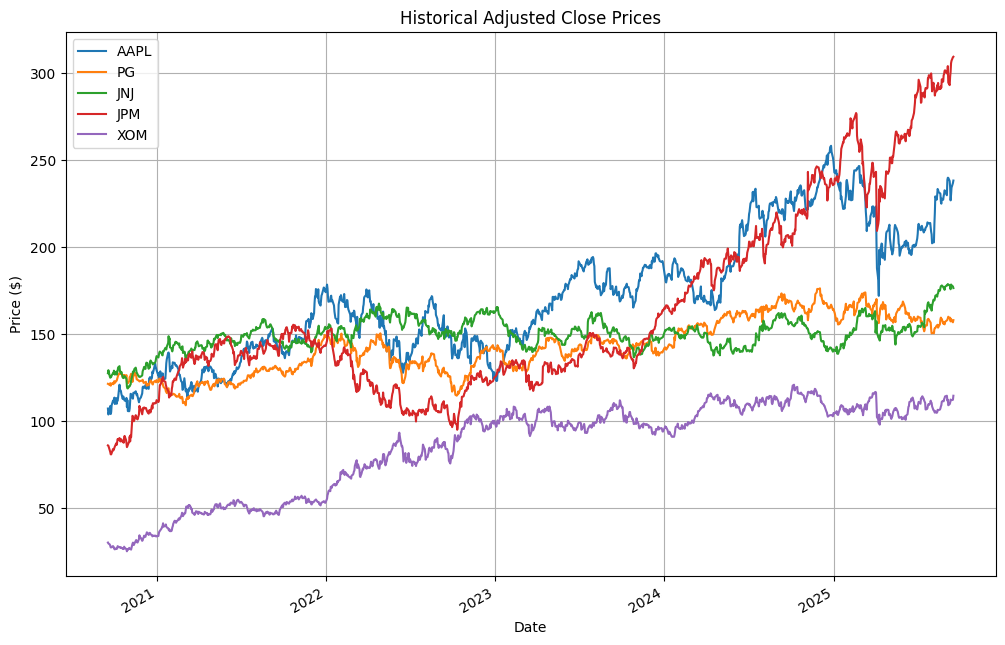

In [ ]:
tickers = ['AAPL', 'PG', 'JNJ', 'JPM', 'XOM']

# Set the time period for historical data (5-year lookback)
end_date = pd.Timestamp.now()
start_date = end_date - pd.DateOffset(years=5)

# Download historical adjusted close prices from Yahoo Finance
adj_close_df = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date)
    # Note: yfinance now returns adjusted prices in the 'Close' column by default
    adj_close_df[ticker] = data['Close']

# Display the first few rows to verify the data
print("      Historical Adjusted Close Prices      ")
print(adj_close_df.head(3))

# Calculate daily logarithmic returns
# Log returns are preferred for financial analysis due to their time-additive property
log_returns = np.log(adj_close_df / adj_close_df.shift(1))
log_returns = log_returns.dropna() # Drop the first row of NaNs

print("\n          Daily Logarithmic Returns      ")
print(log_returns.head(3))

#  Visualize the price history of the assets
adj_close_df.plot(figsize=(12, 8), title='Historical Adjusted Close Prices')
plt.ylabel('Price ($)')
plt.xlabel('Date')
plt.grid(True)
# Save the plot as an image file in your project folder
plt.savefig('historical_prices.png', dpi=300) 
plt.show()

# 1. Monte Carlo Simulation


Running Monte Carlo Simulation...
Simulation Complete.


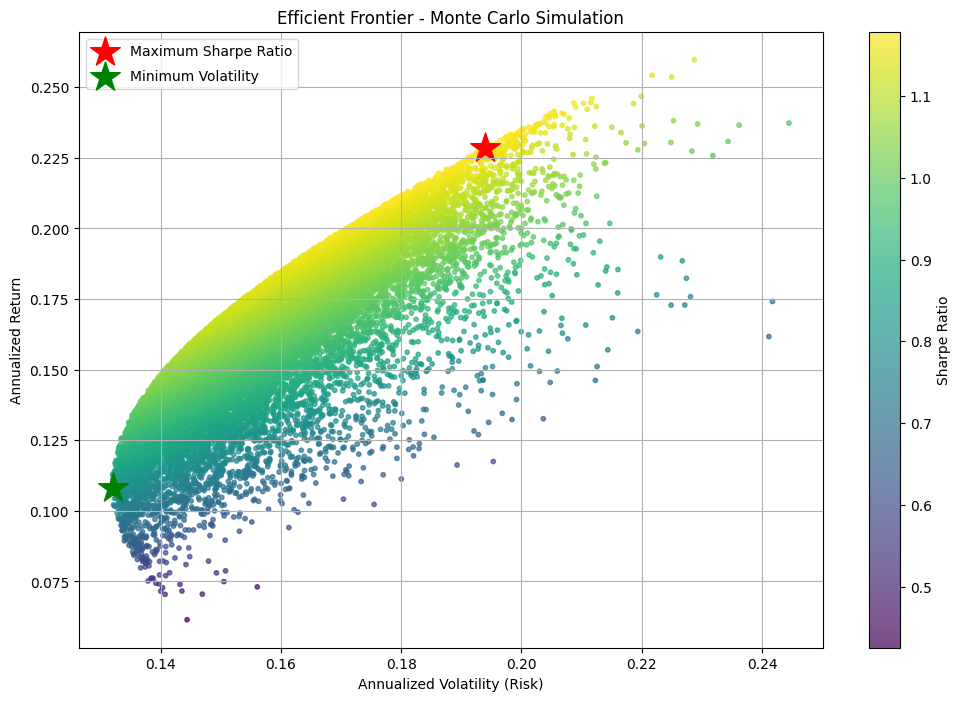

--------------------------------------------------------------------------------
Portfolio with Maximum Sharpe Ratio (Optimal Risky Portfolio):
return          0.228640
volatility      0.194020
sharpe_ratio    1.178435
Name: 21251, dtype: float64
  AAPL: 10.97%
  PG: 2.51%
  JNJ: 8.14%
  JPM: 45.70%
  XOM: 32.67%

--------------------------------------------------------------------------------
Portfolio with Minimum Volatility (Global Minimum Variance):
return          0.107987
volatility      0.132028
sharpe_ratio    0.817907
Name: 12265, dtype: float64
  AAPL: 5.87%
  PG: 38.48%
  JNJ: 34.29%
  JPM: 10.24%
  XOM: 11.12%
--------------------------------------------------------------------------------


In [ ]:
# Annualize daily log returns and covariance (assuming 252 trading days in a year)
mean_returns = log_returns.mean() * 252
cov_matrix = log_returns.cov() * 252

# Set the number of portfolios to simulate
num_portfolios = 25000

# Initialize arrays to store the results: [return, volatility, sharpe_ratio]
results = np.zeros((3, num_portfolios))
# Keep track of the weights for each simulated portfolio
weights_record = []

# --- Run the Monte Carlo Simulation ---

print("\nRunning Monte Carlo Simulation...")
for i in range(num_portfolios):
    #  Generate random weights for the portfolio
    weights = np.random.random(len(tickers))
    # Normalize weights so they sum to 1
    weights /= np.sum(weights)
    weights_record.append(weights)
    
    #  Calculate the annualized portfolio return and volatility
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    #  Store the results
    results[0,i] = portfolio_return
    results[1,i] = portfolio_std_dev
    # Calculate Sharpe Ratio (assuming a risk-free rate of 0)
    results[2,i] = results[0,i] / results[1,i]

print("Simulation Complete.")

# Create a DataFrame from the results array for easier analysis
results_df = pd.DataFrame({
    'return': results[0],
    'volatility': results[1],
    'sharpe_ratio': results[2]
})

# Identify the two key portfolios on the frontier
max_sharpe_portfolio = results_df.loc[results_df['sharpe_ratio'].idxmax()]
# Portfolio with the minimum volatility (Global Minimum Variance Portfolio)
min_vol_portfolio = results_df.loc[results_df['volatility'].idxmin()]

# Create the scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(results_df['volatility'], results_df['return'], c=results_df['sharpe_ratio'], cmap='viridis', marker='o', s=10, alpha=0.7)
plt.colorbar(label='Sharpe Ratio')
plt.title('Efficient Frontier - Monte Carlo Simulation')
plt.xlabel('Annualized Volatility (Risk)')
plt.ylabel('Annualized Return')

# Highlight the two key portfolios with large star markers
plt.scatter(max_sharpe_portfolio['volatility'], max_sharpe_portfolio['return'], marker='*', color='r', s=500, label='Maximum Sharpe Ratio')
plt.scatter(min_vol_portfolio['volatility'], min_vol_portfolio['return'], marker='*', color='g', s=500, label='Minimum Volatility')

plt.legend(labelspacing=0.8)
plt.grid(True)
plt.savefig('efficient_frontier.png', dpi=300)
plt.show()


print("-" * 80)
print("Portfolio with Maximum Sharpe Ratio (Optimal Risky Portfolio):")
print(max_sharpe_portfolio)
max_sharpe_weights = weights_record[results_df['sharpe_ratio'].idxmax()]
for i, ticker in enumerate(tickers):
    print(f"  {ticker}: {max_sharpe_weights[i]:.2%}")

print("\n" + "-" * 80)
print("Portfolio with Minimum Volatility (Global Minimum Variance):")
print(min_vol_portfolio)
min_vol_weights = weights_record[results_df['volatility'].idxmin()]
for i, ticker in enumerate(tickers):
    print(f"  {ticker}: {min_vol_weights[i]:.2%}")
print("-" * 80)

###  Finding the Optimal Portfolio

While we used mathematical optimization later for precision, a **Monte Carlo simulation** is an excellent way to visualize the core concept of Modern Portfolio Theory: the **Efficient Frontier**.

#### The Theory Explained

The fundamental idea is that an investor can reduce risk by diversifying their assets. The Efficient Frontier represents the set of "best possible" portfolios that can be constructed from a given set of assets. For every level of risk (volatility), the frontier shows the portfolio with the highest possible expected return. A rational investor will always choose a portfolio on this frontier.

#### Our Approach

We simulate 25,000 different portfolios, each with a random combination of weights for our five stocks. For each portfolio, we calculate its annualized return, annualized volatility (risk), and Sharpe Ratio (risk-adjusted return).

The resulting plot visualizes all possible risk-return combinations. The outer edge of this "bullet" shape forms the Efficient Frontier.

#### Key Portfolios Identified:
*   **Minimum Volatility Portfolio (Green Star):** This is the safest possible combination of these assets, offering the lowest risk regardless of return. It's ideal for a highly risk-averse investor.
*   **Maximum Sharpe Ratio Portfolio (Red Star):** This portfolio is considered the "optimal risky portfolio." It provides the best possible return for each unit of risk taken. Our primary goal is to identify this portfolio.


# 2. Define Optimization Parameters

In [ ]:

# Number of assets in the portfolio
num_assets = len(tickers)

# Define constraints: the sum of weights must be 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Define bounds for each weight: between 0 and 1 (no short selling)
bounds = tuple((0, 1) for asset in range(num_assets))

# Set the initial guess for the weights (equal distribution)
initial_weights = num_assets * [1. / num_assets,]

# A utility function to calculate annualized portfolio statistics
def get_portfolio_stats(weights, mean_returns, cov_matrix):
    daily_return = np.sum(mean_returns * weights)
    daily_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    annualized_return = daily_return * 252
    annualized_volatility = daily_volatility * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility
    
    return annualized_return, annualized_volatility, sharpe_ratio

# Objective function to MINIMIZE the NEGATIVE Sharpe Ratio
def neg_sharpe_ratio(weights, mean_returns, cov_matrix):
    p_return = np.sum(mean_returns * weights)
    p_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -(p_return / p_std_dev)

# Objective function to MINIMIZE portfolio volatility
def portfolio_volatility(weights, mean_returns, cov_matrix):
    daily_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return daily_volatility * np.sqrt(252)


print("\nRunning Mathematical Optimization...")

# Find the portfolio that maximizes the Sharpe Ratio
max_sharpe_solution = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns.mean(), log_returns.cov()),
                               method='SLSQP', bounds=bounds, constraints=constraints)

# Find the portfolio that minimizes volatility
min_vol_solution = minimize(portfolio_volatility, initial_weights, args=(log_returns.mean(), log_returns.cov()),
                            method='SLSQP', bounds=bounds, constraints=constraints)

print("Optimization Complete.")

# Extract the optimal weights from the solver's results
max_sharpe_weights_opt = max_sharpe_solution.x
min_vol_weights_opt = min_vol_solution.x

# Calculate the final statistics for the two optimal portfolios
max_sharpe_stats = get_portfolio_stats(max_sharpe_weights_opt, log_returns.mean(), log_returns.cov())
min_vol_stats = get_portfolio_stats(min_vol_weights_opt, log_returns.mean(), log_returns.cov())

print("\n" + "="*80)
print("OPTIMIZATION RESULTS")
print("="*80)

print("\nPortfolio with Maximum Sharpe Ratio (Optimized):")
print(f"  Annualized Return: {max_sharpe_stats[0]:.2%}")
print(f"  Annualized Volatility: {max_sharpe_stats[1]:.2%}")
print(f"  Sharpe Ratio: {max_sharpe_stats[2]:.4f}")
print("  Optimal Weights:")
for i, ticker in enumerate(tickers):
    print(f"    {ticker}: {max_sharpe_weights_opt[i]:.2%}")

print("\n" + "-" * 80)

print("\nPortfolio with Minimum Volatility (Optimized):")
print(f"  Annualized Return: {min_vol_stats[0]:.2%}")
print(f"  Annualized Volatility: {min_vol_stats[1]:.2%}")
print(f"  Sharpe Ratio: {min_vol_stats[2]:.4f}")
print("  Optimal Weights:")
for i, ticker in enumerate(tickers):
    print(f"    {ticker}: {min_vol_weights_opt[i]:.2%}")
print("-" * 80)



Running Mathematical Optimization...
Optimization Complete.

OPTIMIZATION RESULTS

Portfolio with Maximum Sharpe Ratio (Optimized):
  Annualized Return: 22.30%
  Annualized Volatility: 18.91%
  Sharpe Ratio: 1.1793
  Optimal Weights:
    AAPL: 11.67%
    PG: 5.73%
    JNJ: 7.28%
    JPM: 42.81%
    XOM: 32.50%

--------------------------------------------------------------------------------

Portfolio with Minimum Volatility (Optimized):
  Annualized Return: 10.90%
  Annualized Volatility: 13.19%
  Sharpe Ratio: 0.8259
  Optimal Weights:
    AAPL: 6.88%
    PG: 35.96%
    JNJ: 35.97%
    JPM: 9.62%
    XOM: 11.56%
--------------------------------------------------------------------------------


###  Precise Portfolio Optimization with SciPy

While the Monte Carlo simulation provides an excellent visual intuition, it is a brute-force method that relies on random sampling. To find the *true* optimal portfolio, we use a mathematical solver. The `scipy.optimize` library provides the powerful **Sequential Least Squares Programming (SLSQP)** algorithm, perfect for this kind of constrained optimization problem.

#### The Optimization Problem

We define two distinct goals (objective functions) for the optimizer:

1.  **Maximize Sharpe Ratio:** Since optimizers typically *minimize* functions, we achieve this by instructing the solver to minimize the *negative* Sharpe Ratio.
2.  **Minimize Volatility:** This is a straightforward minimization of the portfolio's annualized volatility.

For both scenarios, we impose two critical constraints:
*   **Fully Invested:** The sum of all asset weights must equal 1.
*   **No Short Selling:** The weight of each asset must be between 0 and 1.

#### The Results

The optimizer provides a precise and deterministic solution, which we will use for all subsequent analysis.


# 3. Advanced Risk Analysis (VaR & CVaR) 

In [ ]:
print("\n" + "="*80)
print("RISK ANALYSIS: Value at Risk (VaR) & Conditional VaR (CVaR)")
print("="*80)

# We use the optimal weights from the previous step and the daily log returns of the individual assets.
optimal_portfolio_returns = log_returns.dot(max_sharpe_weights_opt)

# Define parameters for the risk analysis
hypothetical_value = 100000 
confidence_level = 0.95

# VaR at a given confidence level is the quantile of the historical returns distribution.
var_95 = optimal_portfolio_returns.quantile(1 - confidence_level)

# Convert the VaR percentage to a monetary value
var_95_value = var_95 * hypothetical_value

print(f"\nAnalysis for a hypothetical investment of ${hypothetical_value:,.2f} at a {confidence_level:.0%} confidence level:\n")
print(f"Daily Historical VaR (95%): {var_95:.2%}")
print(f"This means we are 95% confident that the daily loss will not exceed ${-var_95_value:,.2f}.")

# CVaR is the average of all returns that are worse than the VaR.
cvar_95 = optimal_portfolio_returns[optimal_portfolio_returns <= var_95].mean()

# Convert the CVaR percentage to a monetary value
cvar_95_value = cvar_95 * hypothetical_value

print(f"\nDaily Historical CVaR (95%): {cvar_95:.2%}")
print(f"This means that on the worst 5% of days, the *average* expected loss is ${-cvar_95_value:,.2f}.")
print("-" * 80)


RISK ANALYSIS: Value at Risk (VaR) & Conditional VaR (CVaR)

Analysis for a hypothetical investment of $100,000.00 at a 95% confidence level:

Daily Historical VaR (95%): -1.89%
This means we are 95% confident that the daily loss will not exceed $1,890.82.

Daily Historical CVaR (95%): -2.56%
This means that on the worst 5% of days, the *average* expected loss is $2,564.88.
--------------------------------------------------------------------------------


###  Advanced Risk Analysis

While volatility is a useful measure of risk, it doesn't provide an intuitive sense of potential monetary losses. To address this, we calculate two key industry-standard risk metrics: **Value at Risk (VaR)** and **Conditional Value at Risk (CVaR)**.

We use the historical simulation method, which leverages the actual historical return distribution of our optimized portfolio to estimate future risk.

*   **Value at Risk (VaR):** Answers the question, "What is the maximum amount I can expect to lose on a given day with a specific level of confidence?" A 95% VaR, for instance, represents the loss threshold that we don't expect to be breached on 95 out of 100 days.

*   **Conditional Value at Risk (CVaR):** Also known as Expected Shortfall, CVaR goes a step further. It answers the question, "If I do have a really bad day (i.e., I breach the VaR threshold), what is my *average* expected loss?" It quantifies the risk in the "tail" of the distribution.

#### Risk Profile of the Optimal Portfolio

The analysis provides a clear, dollar-denominated risk assessment for a hypothetical $100,000 investment.

```text
================================================================================
RISK ANALYSIS: Value at Risk (VaR) & Conditional VaR (CVaR)
================================================================================

Analysis for a hypothetical investment of $100,000.00 at a 95% confidence level:

Daily Historical VaR (95%): -1.89%
This means we are 95% confident that the daily loss will not exceed $1,890.82.

Daily Historical CVaR (95%): -2.56%
This means that on the worst 5% of days, the *average* expected loss is $2,564.88.
--------------------------------------------------------------------------------

# 4. Strategy Backtesting Engine


Running Backtest...


[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed


Backtest Complete.


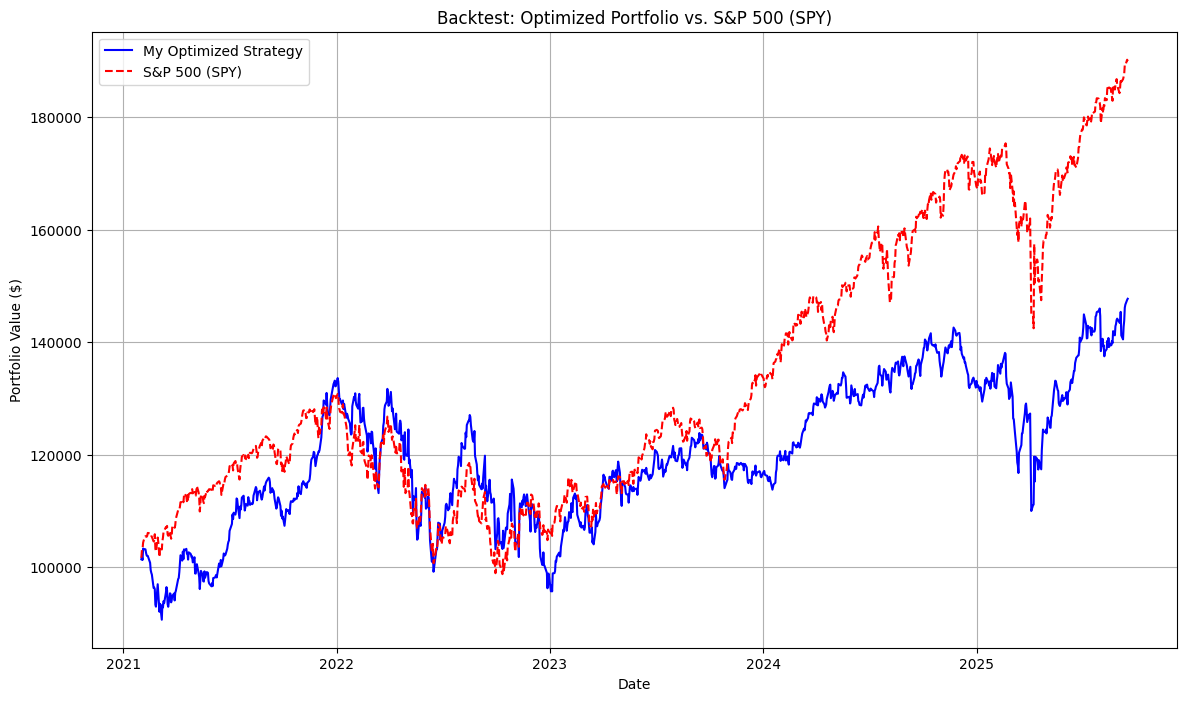


--- Final Results ---
Initial Capital: $100,000.00
Final Value (My Strategy): $147,725.25
Final Value (S&P 500): $189,964.71


In [ ]:
print("\nRunning Backtest...")

# Download a longer history of data to allow for the rolling lookback period
backtest_start_date = '2018-01-01'
end_date_now = pd.Timestamp.now() # Use a consistent end date

# Download asset and benchmark (SPY) data for the backtest period
all_data = yf.download(tickers, start=backtest_start_date, end=end_date_now)['Close']
spy_data = yf.download('SPY', start=backtest_start_date, end=end_date_now)['Close']

# Calculate log returns for the entire backtest period
all_log_returns = np.log(all_data / all_data.shift(1)).dropna()
spy_log_returns = np.log(spy_data / spy_data.shift(1)).dropna()

# Set Backtesting Parameters
rebalance_frequency = 6  # months
lookback_period = 36     # months (3 years)
initial_capital = 100000

# Generate rebalancing dates (e.g., the start of every 6th month)
rebalance_dates = pd.date_range(
    start=all_log_returns.index.min() + pd.DateOffset(months=lookback_period),
    end=all_log_returns.index.max(),
    freq=f'{rebalance_frequency}MS' # 'MS' for Month Start frequency
)

# Initialize a Series to store the portfolio's value over time
portfolio_values = pd.Series(index=all_log_returns.index)
current_capital = initial_capital

# Iterate through each rebalancing date to update portfolio weights
for i, date in enumerate(rebalance_dates):
    # Define the 3-year lookback window for this rebalance date
    start_period = date - pd.DateOffset(months=lookback_period)
    lookback_data = all_log_returns.loc[start_period:date]
    
    # Run the optimizer on the lookback data to find the new optimal weights
    mean_ret = lookback_data.mean()
    cov_mat = lookback_data.cov()
    
    sol = minimize(neg_sharpe_ratio, initial_weights, args=(mean_ret, cov_mat),
                   method='SLSQP', bounds=bounds, constraints=constraints)
    optimal_weights = sol.x
    
    # Define the holding period (from this rebalance date to the next)
    hold_start_date = date
    hold_end_date = rebalance_dates[i+1] if i+1 < len(rebalance_dates) else all_log_returns.index.max()
    
    # Get the actual returns during the holding period
    holding_returns_data = all_log_returns.loc[hold_start_date:hold_end_date]
    
    # Calculate the daily returns of our strategy's portfolio
    portfolio_period_returns = holding_returns_data.dot(optimal_weights)
    
    # Convert log returns to simple returns to calculate the equity curve
    period_simple_returns = np.exp(portfolio_period_returns) - 1
    period_equity_curve = current_capital * (1 + period_simple_returns).cumprod()
    
    # Store the daily portfolio values for this period
    portfolio_values.loc[period_equity_curve.index] = period_equity_curve
    
    # Update the capital for the next iteration
    if not period_equity_curve.empty:
        current_capital = period_equity_curve.iloc[-1]

# Remove any leading NaN values from the portfolio value series
portfolio_values = portfolio_values.dropna()

# Calculate the equity curve for the benchmark (SPY) for the same period
spy_simple_returns = np.exp(spy_log_returns.loc[portfolio_values.index]) - 1
spy_equity_curve = initial_capital * (1 + spy_simple_returns).cumprod()

print("Backtest Complete.")

# Visualize the Backtest Results
plt.figure(figsize=(14, 8))
plt.title('Backtest: Optimized Portfolio vs. S&P 500 (SPY)')
plt.plot(portfolio_values.index, portfolio_values, label='My Optimized Strategy', color='blue')
plt.plot(spy_equity_curve.index, spy_equity_curve, label='S&P 500 (SPY)', color='red', linestyle='--')
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.savefig('backtest_equity_curve.png', dpi=300)
plt.show()

# 6. Print Final Performance Summary
print("\n--- Final Results ---")
print(f"Initial Capital: ${initial_capital:,.2f}")
if not portfolio_values.empty:
    print(f"Final Value (My Strategy): ${float(portfolio_values.iloc[-1]):,.2f}")
if not spy_equity_curve.empty:
    print(f"Final Value (S&P 500): ${float(spy_equity_curve.iloc[-1]):,.2f}")

###  Strategy Backtesting

A theoretical optimal portfolio is only useful if it performs well in practice. To assess this, we built a custom backtesting engine to simulate the performance of our portfolio optimization strategy against a simple buy-and-hold strategy of the S&P 500 ETF (`SPY`).

#### Backtesting Methodology:
*   **Initial Capital:** $100,000
*   **Lookback Period:** 36 months (3 years). At each decision point, the optimizer uses the last 3 years of data to determine the optimal weights.
*   **Rebalancing Frequency:** 6 months. Every six months, we recalculate the optimal portfolio and rebalance our holdings to match the new target weights.
*   **Benchmark:** S&P 500 ETF (`SPY`).

The engine iterates through time, periodically re-optimizing and tracking the growth of our initial capital.


#### Initial Findings:

The visual evidence immediately suggests that our strategy **underperformed** the benchmark. While it tracked the market's general direction, it failed to capture the same upside, particularly from 2023 onwards. This highlights a critical lesson in quantitative finance: a strategy that is optimal based on past data is not guaranteed to outperform in the future.

The final values confirm the visual story:
```text
--- Final Results ---
Initial Capital: $100,000.00
Final Value (My Strategy): $147,725.25
Final Value (S&P 500): $189,964.71

# 5. Strategy Performance Metrics

In [10]:
# Ensure both are pandas Series for consistent calculations
strategy_daily_returns = portfolio_values.pct_change().dropna()
spy_daily_returns = spy_equity_curve.squeeze().pct_change().dropna()

# Define a function to calculate all key performance metrics
def calculate_performance_metrics(returns):
    """
    Calculates key performance metrics from a Series of daily returns.
    """
    # Assume 252 trading days in a year
    trading_days = 252
    
    # Annualized Return
    annualized_return = returns.mean() * trading_days
    
    # Annualized Volatility (Risk)
    annualized_volatility = returns.std() * np.sqrt(trading_days)
    
    # Sharpe Ratio (assuming risk-free rate is 0)
    sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else 0
    
    # Maximum Drawdown (the largest peak-to-trough drop)
    wealth_index = (1 + returns).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks) / previous_peaks
    max_drawdown = drawdowns.min()
    
    # Calmar Ratio (Annualized Return / Absolute Max Drawdown)
    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else 0
    
    # Return a dictionary of formatted metrics
    return {
        "Annualized Return": f"{annualized_return:.2%}",
        "Annualized Volatility": f"{annualized_volatility:.2%}",
        "Sharpe Ratio": f"{sharpe_ratio:.2f}",
        "Maximum Drawdown": f"{max_drawdown:.2%}",
        "Calmar Ratio": f"{calmar_ratio:.2f}"
    }

#  Calculate and display the metrics for both the strategy and the benchmark
strategy_metrics = calculate_performance_metrics(strategy_daily_returns)
spy_metrics = calculate_performance_metrics(spy_daily_returns)

# Create a DataFrame for a clean, side-by-side comparison
results_df = pd.DataFrame({
    'Optimized Strategy': strategy_metrics,
    'S&P 500 (SPY)': spy_metrics
})

print("\n" + "="*80)
print("STRATEGY PERFORMANCE METRICS")
print("="*80)
print(results_df)



STRATEGY PERFORMANCE METRICS
                      Optimized Strategy S&P 500 (SPY)
Annualized Return                 10.38%        15.08%
Annualized Volatility             21.05%        17.40%
Sharpe Ratio                        0.49          0.87
Maximum Drawdown                 -28.38%       -24.50%
Calmar Ratio                        0.37          0.62


### The backtest results demonstrate conclusively that, for the specified period and parameters, this Max Sharpe Ratio optimization strategy failed to outperform the S&P 500 benchmark.

Not only did the strategy produce a significantly lower annualized return (10.38% vs. 15.08%), but it did so while undertaking higher risk. This is evidenced by its higher volatility and a larger maximum drawdown. The Sharpe Ratio, the primary measure of risk-adjusted return, was nearly half that of the benchmark (0.49 vs. 0.87), confirming that the strategy was far less efficient at generating returns for the risk involved.

This outcome is not a failure of the project, but rather its most valuable insight. It successfully highlights that:

Beating the market is extremely difficult. A diversified, passive index is a formidable opponent.
Past performance is not indicative of future results. A portfolio optimized on historical data can easily underperform when market conditions change.
The value of a robust backtesting framework is its ability to objectively validate or invalidate a strategy before deploying real capital.